In [1]:
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from tqdm import tqdm
import pickle
import random
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.downloader
from torch import FloatTensor as FT

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

plt.style.use('ggplot')

c:\Users\Alex\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
torch.cuda.is_available()


True

### Instructions
For this part, fill in the required code and make the notebook work. This wll be very similar to the Skip-Gram model, but a little more difficult. Look for the """ FILL IN """ string to guide you.

In [3]:
# Where do I want to run my job. You can do "cuda" on linux machines.
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# The batch size in Adam or SGD.
BATCH_SIZE = 512
# Number of epochs.
NUM_EPOCHS = 10
# Predict from 2 words the inner word for CBOW.
# I.e. I'll have a window like ["a", "b", "c"] of continuous text (each is a word).
# We'll predict each of wc = ["a", "c"] from "b" = wc for Skip-Gram.
# For CBOW, we'll use ["a", "c"] to predict "b" = wo.
WINDOW = 1

# Negative samples.
K = 4

The text8 Wikipedia corpus. 100M characters.

In [4]:
!du -h text8

'du' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
f = open('text8', 'r')
text = f.read()
# One big string of size 100M.
print(len(text))

100000000


In [6]:
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_\'{|}~\t\n'

# Can do regular expressions here too.
for c in punc:
    if c in text:
        text.replace(c, ' ')

In [7]:
# A very crude tokenizer you get for free: lower case and also split on spaces.
TOKENIZER = get_tokenizer("basic_english")

In [8]:
words = TOKENIZER(text)
f = Counter(words)

In [9]:
len(words)

17005207

In [10]:
# Do a very crude filter on the text which removes all very popular words.
text = [word for word in words if f[word] > 5]

In [11]:
text[0:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [12]:
VOCAB = build_vocab_from_iterator([text])

In [13]:
# word -> int hash map.
stoi = VOCAB.get_stoi()
# int -> word hash map.
itos = VOCAB.get_itos() 

In [14]:
stoi['as']

11

In [15]:
# Total number of words.
len(stoi)

63641

In [16]:
f = Counter(text)
# This is the probability that we pick a word in the corpus.
z = {word: f[word] / len(text) for word in f}

In [17]:
threshold = 1e-5
# Probability that word is kept while subsampling.
# This is explained here and sightly differet from the paper: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
p_keep = {word: (np.sqrt(z[word] / 0.001) + 1)*(0.0001 / z[word]) for word in f}

In [18]:
# This is in the integer space.
train_dataset = [word for word in text if random.random() < p_keep[word]]

# Rebuild the vocabulary.
VOCAB = build_vocab_from_iterator([train_dataset])

In [19]:
len(train_dataset)

7845879

In [20]:
# word -> int mapping.
stoi = VOCAB.get_stoi()
# int -> word mapping.
itos = VOCAB.get_itos() 

In [21]:
# The vocabulary size after we do all the filters.
len(VOCAB)

63641

In [22]:
# The probability we draw something for negative sampling.
f = Counter(train_dataset)
p = torch.zeros(len(VOCAB))

# Downsample frequent words and upsample less frequent.
s = sum([np.power(freq, 0.75) for word, freq in f.items()])        

for word in f:
    p[stoi[word]] = np.power(f[word], 0.75) / s

In [23]:
# Map everything to integers.
train_dataset = [stoi[word] for word in text]

In [24]:
# This just gets the (wc, wo) pairs that are positive - they are seen together!
def get_tokenized_dataset(dataset, verbose=False):
    x_list = []
        
    for i, token in enumerate(dataset):
        m = 1
        
        # Get the left and right tokens.
        start = max(0,i-m)
        left_tokens = dataset[start:i]
        
        end = min(i+m,len(dataset)-1)
        right_tokens = dataset[i+1:end+1]
        
        # Check these are the same length, and if so use them to add a row of data. This should be a list like.
        # [a, c, b] where b is the center word.
        if len(left_tokens) == len(right_tokens):
            w_context = left_tokens + right_tokens
            
            wc = token
                        
            x_list.extend(
                [w_context + [wc]]
            )
            
    return x_list

In [25]:
train_x_list = get_tokenized_dataset(train_dataset, verbose=False)

In [26]:
pickle.dump(train_x_list, open('train_x_list.pkl', 'wb'))

In [27]:
train_x_list = pickle.load(open('train_x_list.pkl', 'rb'))

In [28]:
# These are (wc, wo) pairs. All are y = +1 by design.
train_x_list[:10]

[[5233, 12, 3083],
 [3083, 5, 12],
 [12, 174, 5],
 [5, 1, 174],
 [174, 3133, 1],
 [1, 45, 3133],
 [3133, 58, 45],
 [45, 177, 58],
 [58, 117, 177],
 [177, 741, 117]]

In [29]:
len(train_x_list)// BATCH_SIZE

32579

In [30]:
# The number of things of BATCH_SIZE = 512.
assert(len(train_x_list) // BATCH_SIZE == 32579)

### Set up the dataloader.

In [31]:
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_x_list).to(DEVICE),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [32]:
for xb in train_dl:
    assert(xb[0].shape == (BATCH_SIZE, 3))
    break

### Words we'll use to asses the quality of the model ...

In [33]:
valid_ids = torch.tensor([
    stoi['money'],
    stoi['lion'],
    stoi['africa'],
    stoi['musician'],
    stoi['dance'],
])

### Get the model.

In [34]:
class CBOWNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOWNegativeSampling, self).__init__()
        self.A = nn.Embedding(vocab_size, embed_dim) # Context vectors - center word.
        self.B = nn.Embedding(vocab_size, embed_dim) # Output vectors - words around the center word.
        self.init_weights()

    def init_weights(self):
        # Is this the best way? Not sure.
        initrange = 0.5
        self.A.weight.data.uniform_(-initrange, initrange)
        self.B.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # N is the batch size.
        # x is (N, 3)
        
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc = x[:,0:2], x[:,2]
                
        # Each of these is (N, 2, D) since each context has 2 word.
        # We want this to be (N, D) and this is what we get.
        
        # (N, 2, D)
        a = self.A(w_context)
        
        # (N, D)
        a_avg = torch.mean(a, dim=1)
        
        # Each of these is (N, D) since each target has 1 word.
        b = self.B(wc)
      
        # The product between each context and target vector. Look at the Skip-Gram code.
        # The logits is now (N, 1) since we sum across the final dimension.
        logits = torch.sum(a_avg*b, dim=1).to(DEVICE)
                
        return logits

In [35]:
@torch.no_grad()
def validate_embeddings(
    model,
    valid_ids,
    itos
):
    """ Validation logic """

    # We will use context embeddings to get the most similar words
    # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
    embedding_weights = model.A.weight
        
    normalized_embeddings = embedding_weights.cpu() / np.sqrt(
        np.sum(embedding_weights.cpu().numpy()**2, axis=1, keepdims=True)
    )

    # Get the embeddings corresponding to valid_term_ids
    valid_embeddings = normalized_embeddings[valid_ids, :]

    # Compute the similarity between valid_term_ids (S) and all the embeddings (V).
    # We do S x d (d x V) => S x D and sort by negative similarity.
    top_k = 10 # Top k items will be displayed.
    similarity = np.dot(valid_embeddings.cpu().numpy(), normalized_embeddings.cpu().numpy().T)

    # Invert similarity matrix to negative
    # Ignore the first one because that would be the same word as the probe word
    similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

    # Print the output.
    for i, word_id in enumerate(valid_ids):
        # j >= 1 here since we don't want to include the word itself.
        similar_word_str = ', '.join([itos[j] for j in similarity_top_k[i, :] if j >= 1])
        print(f"{itos[word_id]}: {similar_word_str}")

    print('\n')

### Set up the model

In [36]:
LR = 10.0
NUM_EPOCHS = 10
EMBED_DIM = 300

In [37]:
model = CBOWNegativeSampling(len(VOCAB), EMBED_DIM).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# The learning rate is lowered every epoch by 1/10.
# Is this a good idea?
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)

In [38]:
model

CBOWNegativeSampling(
  (A): Embedding(63641, 300)
  (B): Embedding(63641, 300)
)

In [39]:
validate_embeddings(model, valid_ids, itos)

money: mjf, reckoning, citymayors, airtime, trustees, aengus, renting, wormholes, teutonic, copper
lion: marge, loam, participated, neatly, impart, race, matlab, reconstructing, prince, interleague
africa: squeezing, shrews, freleng, lid, mindy, outclassed, brigitte, endothelial, koo, heartbreaker
musician: armature, priesthoods, banacek, devour, televangelist, kaveri, mogens, cato, cloned, lamiaceae
dance: adirondack, dontrelle, grouping, buscema, bres, transhumanism, final, winningest, overturn, syntax




### Train the model

In [40]:
ratios = []

def train(dataloader, model, optimizer, epoch):
    model.train()
    total_acc, total_count, total_loss, total_batches = 0, 0, 0.0, 0.0
    log_interval = 500
    
    for idx, x_batch in tqdm(enumerate(dataloader)):
        
        x_batch = x_batch[0]
                
        batch_size = x_batch.shape[0]
        
        # Zero the gradient so they don't accumulate.
        optimizer.zero_grad()
        
        logits = model(x_batch)
                        
        # Get the positive samples loss. Notice we use weights here.
        positive_loss = torch.nn.BCEWithLogitsLoss()(input=logits, target=torch.ones(batch_size).to(DEVICE).float())
        
        # For each batch, get some negative samples.
        # We need a total of len(y_batch) * 2* WINDOW * K samples across a batch.
        # We then reshape this batch.
        # These are effectively the output words.
        
        negative_samples = torch.multinomial(p, batch_size * K, replacement=True)
        # print("negative_samples", negative_samples.size())

        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc = x_batch[:,0:2].to('cpu'), negative_samples 
        # print("w_context", w_context.size())
        # print("wc", wc.size())

        """
        if w_context looks like below (batch_size = 3)
        [
        (a, b),
        (c, d),
        (e, f)
        ] and K = 2 we'd like to get:
        
        [
        (a, b),
        (a, b),
        (c, d), 
        (c, d),
        (e, f),
        (e, f)
        ]
        
        This will be batch_size * K rows.
        """
        
        # This should be (N * K, 2)
        w_context = torch.concat([
            w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
        ])
        
        # Remove the last dimension 1.
        
        wc = wc.view(wc.size()[0],1)
        # print("w_context", w_context.size())
        # print("wc", wc.size())

        # Get the negative samples. This should be (N * K, 3).
        # Concatenate the w_context and wc along the column. Make sure everything is on CUDA / MPS or CPU.
        x_batch_negative = torch.cat([w_context, wc], axis = 1).to(DEVICE)
                
        """
        Note the way we formulated the targets: they are all 0 since these are negative samples.
        We do the BCEWithLogitsLoss by hand basically here.
        Notice we sum across the negative samples, per positive word.
        
        This is literally the equation in the lecture notes.
        """
        
        # (N, K, D) -> (N, D) -> (N)
        # Look at the Skip-Gram notebook.
        negative_loss = model(x_batch_negative).neg().sigmoid().log().reshape(
            batch_size, K
        ).sum(1).mean().neg().to(DEVICE)
        
        loss = (positive_loss + negative_loss).mean()
                
        # Get the gradients via back propagation. 
        loss.backward()
                        
        # Clip the gradients? Generally a good idea.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Used for optimization. This should be roughly 0.001, on average.
        # You can use this to see if your learning rate is right - you can also plot the loss performance.
        with torch.no_grad():
            r = [
                (LR * p.grad.std() / p.data.std()).log10().item() for _, p in model.named_parameters()
            ]
            ratios.append(r)  
        
        # Do an optimization step. Update the parameters A and B.
        optimizer.step()
        # Get the new loss.
        total_loss += loss.item()
        # Update the batch count.
        total_batches += 1
                
        if idx % log_interval == 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| loss {:8.3f} ".format(
                    epoch,
                    idx,
                    len(dataloader),
                    total_loss / total_batches
                )
            )
            validate_embeddings(model, valid_ids, itos)
            total_loss, total_batches = 0.0, 0.0

### Some results from the run look like below:

Somewhere inside of 2 iterations you should get sensible associattions.
Paste here a screenshot of the closest vectors.

In [41]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    
    train(train_dl, model, optimizer, epoch)
    # We have a learning rate scheduler here.
    # Basically, given the state of the optimizer, this lowers the learning rate in a smart way.
    scheduler.step()

0it [00:00, ?it/s]C:\Users\Alex\AppData\Local\Temp\ipykernel_24028\973106114.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
1it [00:00,  1.23it/s]

| epoch   1 |     0/32580 batches | loss    4.079 
money: mjf, reckoning, citymayors, airtime, trustees, aengus, renting, wormholes, teutonic, copper
lion: marge, loam, participated, neatly, impart, race, matlab, reconstructing, prince, interleague
africa: squeezing, shrews, freleng, lid, mindy, outclassed, brigitte, endothelial, koo, heartbreaker
musician: armature, priesthoods, banacek, devour, televangelist, kaveri, mogens, cato, cloned, lamiaceae
dance: adirondack, dontrelle, grouping, buscema, bres, transhumanism, final, winningest, overturn, syntax




505it [00:08, 56.65it/s]

| epoch   1 |   500/32580 batches | loss    3.720 
money: mjf, reckoning, citymayors, airtime, trustees, aengus, renting, wormholes, teutonic, logrus
lion: marge, loam, participated, neatly, impart, race, matlab, prince, reconstructing, interleague
africa: squeezing, shrews, lid, mindy, outclassed, freleng, brigitte, koo, endothelial, heartbreaker
musician: armature, priesthoods, banacek, devour, televangelist, kaveri, mogens, lamiaceae, cato, cloned
dance: adirondack, dontrelle, grouping, buscema, bres, transhumanism, final, winningest, syntax, althea




1008it [00:14, 58.77it/s]

| epoch   1 |  1000/32580 batches | loss    3.358 
money: mjf, reckoning, citymayors, airtime, trustees, aengus, renting, wormholes, teutonic, inexorably
lion: marge, participated, loam, neatly, impart, race, prince, matlab, reconstructing, interleague
africa: shrews, squeezing, mindy, outclassed, lid, brigitte, freleng, koo, endothelial, zawahiri
musician: armature, priesthoods, banacek, televangelist, kaveri, devour, mogens, cato, benn, lamiaceae
dance: adirondack, dontrelle, buscema, grouping, bres, transhumanism, final, insurgencies, syntax, althea




1503it [00:21, 58.90it/s]

| epoch   1 |  1500/32580 batches | loss    3.026 
money: mjf, citymayors, reckoning, airtime, trustees, renting, aengus, wormholes, teutonic, inexorably
lion: marge, participated, loam, neatly, impart, race, prince, matlab, reconstructing, interleague
africa: squeezing, shrews, mindy, outclassed, lid, brigitte, zawahiri, freleng, rep, koo
musician: armature, priesthoods, banacek, kaveri, televangelist, devour, mogens, cato, lamiaceae, benn
dance: adirondack, dontrelle, buscema, grouping, bres, transhumanism, final, insurgencies, syntax, althea




2007it [00:28, 58.00it/s]

| epoch   1 |  2000/32580 batches | loss    2.789 
money: mjf, citymayors, airtime, reckoning, trustees, renting, aengus, saxonis, wormholes, inexorably
lion: marge, participated, loam, neatly, impart, race, prince, matlab, reconstructing, emanates
africa: mindy, squeezing, shrews, but, outclassed, zawahiri, lid, freleng, rep, anthropology
musician: armature, priesthoods, kaveri, televangelist, banacek, devour, v, cato, mogens, cloned
dance: adirondack, dontrelle, buscema, bres, final, grouping, transhumanism, heian, insurgencies, winningest




2503it [00:35, 59.71it/s]

| epoch   1 |  2500/32580 batches | loss    2.617 
money: mjf, citymayors, airtime, trustees, reckoning, renting, aengus, scarface, saxonis, sirens
lion: marge, participated, neatly, loam, impart, race, prince, matlab, reconstructing, emanates
africa: mindy, squeezing, but, shrews, zawahiri, lid, outclassed, rep, became, anthropology
musician: armature, priesthoods, kaveri, televangelist, v, banacek, devour, mogens, cato, cloned
dance: adirondack, final, buscema, dontrelle, bres, grouping, heian, insurgencies, transhumanism, althea




3007it [00:42, 57.00it/s]

| epoch   1 |  3000/32580 batches | loss    2.482 
money: mjf, citymayors, airtime, trustees, reckoning, aengus, renting, short, scarface, saxonis
lion: marge, participated, neatly, loam, impart, race, matlab, reconstructing, prince, emanates
africa: but, world, mindy, became, and, k, use, zawahiri, he, group
musician: armature, priesthoods, kaveri, v, televangelist, banacek, devour, cato, cloned, mogens
dance: adirondack, final, dontrelle, buscema, heian, bres, grouping, insurgencies, transhumanism, lesbians




3503it [00:49, 58.79it/s]

| epoch   1 |  3500/32580 batches | loss    2.379 
money: mjf, citymayors, airtime, short, people, church, it, trustees, called, so
lion: marge, participated, loam, neatly, impart, race, reconstructing, prince, matlab, bdeac
africa: world, but, he, two, use, became, b, was, k, group
musician: priesthoods, v, armature, kaveri, televangelist, devour, cato, cloned, banacek, hejira
dance: adirondack, final, dontrelle, heian, buscema, bres, grouping, insurgencies, lesbians, transhumanism




4005it [00:56, 59.00it/s]

| epoch   1 |  4000/32580 batches | loss    2.284 
money: short, called, mjf, so, people, church, citymayors, it, there, often
lion: marge, participated, loam, neatly, impart, race, reconstructing, prince, matlab, bdeac
africa: world, but, use, would, b, had, became, he, made, eight
musician: v, priesthoods, armature, kaveri, televangelist, english, hejira, devour, cato, de
dance: adirondack, final, dontrelle, heian, buscema, bres, insurgencies, stirrups, wolfgang, lesbians




4500it [01:03, 71.87it/s]

| epoch   1 |  4500/32580 batches | loss    2.218 
money: called, so, short, people, often, there, church, world, it, will
lion: marge, participated, loam, race, neatly, impart, reconstructing, bdeac, prince, matlab
africa: world, but, use, b, eight, made, two, would, some, had
musician: v, priesthoods, armature, kaveri, language, english, by, televangelist, hejira, de
dance: final, adirondack, heian, buscema, dontrelle, university, stirrups, insurgencies, bres, wolfgang




5003it [01:10, 58.29it/s]

| epoch   1 |  5000/32580 batches | loss    2.154 
money: called, so, often, people, short, there, it, church, united, them
lion: marge, race, participated, loam, neatly, impart, reconstructing, prince, bdeac, matlab
africa: world, but, use, made, b, group, some, eight, two, became
musician: v, language, english, priesthoods, armature, kaveri, de, us, new, g
dance: final, adirondack, university, buscema, heian, new, dontrelle, natural, stirrups, insurgencies




5508it [01:17, 60.37it/s]

| epoch   1 |  5500/32580 batches | loss    2.104 
money: people, so, often, called, there, short, united, it, them, church
lion: marge, participated, race, loam, impart, neatly, reconstructing, prince, bdeac, matlab
africa: world, use, but, made, b, group, what, part, eight, two
musician: v, english, language, g, original, us, de, new, use, california
dance: final, university, new, adirondack, natural, buscema, heian, dontrelle, through, stirrups




6001it [01:24, 57.47it/s]

| epoch   1 |  6000/32580 batches | loss    2.059 
money: so, people, called, them, united, often, short, c, there, government
lion: marge, race, participated, loam, impart, neatly, reconstructing, prince, bdeac, matlab
africa: world, made, use, part, but, group, what, nine, four, b
musician: v, language, english, original, new, g, us, by, california, use
dance: final, university, new, natural, through, adirondack, four, long, high, eight




6504it [01:31, 58.47it/s]

| epoch   1 |  6500/32580 batches | loss    2.016 
money: people, so, often, them, called, government, united, c, short, church
lion: marge, race, participated, impart, loam, neatly, reconstructing, prince, bdeac, matlab
africa: world, made, use, part, what, nine, group, but, eight, time
musician: v, language, english, original, us, g, new, by, california, de
dance: final, university, new, four, long, through, natural, high, seven, eight




7003it [01:39, 57.62it/s]

| epoch   1 |  7000/32580 batches | loss    1.976 
money: people, so, often, them, government, united, called, c, short, used
lion: marge, race, participated, impart, loam, neatly, reconstructing, prince, bdeac, matlab
africa: world, use, part, made, nine, what, group, eight, time, four
musician: v, language, english, original, us, g, by, new, california, order
dance: final, university, new, long, four, natural, eight, high, zero, through




7505it [01:46, 57.28it/s]

| epoch   1 |  7500/32580 batches | loss    1.945 
money: people, often, government, them, so, united, c, short, called, if
lion: marge, race, participated, impart, loam, neatly, reconstructing, prince, bdeac, matlab
africa: use, world, part, made, what, group, time, nine, eight, but
musician: language, v, english, original, us, g, order, california, de, france
dance: final, university, new, long, natural, zero, four, high, u, state




8006it [01:52, 61.69it/s]

| epoch   1 |  8000/32580 batches | loss    1.914 
money: them, often, so, people, government, united, called, short, c, used
lion: marge, race, participated, impart, loam, neatly, reconstructing, prince, bdeac, programming
africa: part, use, world, made, what, group, time, nine, country, two
musician: language, english, v, original, us, g, led, california, order, c
dance: final, university, new, zero, long, four, high, u, natural, seven




8509it [01:59, 63.38it/s]

| epoch   1 |  8500/32580 batches | loss    1.889 
money: them, so, often, government, people, united, if, called, work, short
lion: race, marge, participated, impart, loam, neatly, reconstructing, prince, bdeac, programming
africa: part, use, world, made, group, what, time, country, nine, them
musician: language, english, v, original, led, order, us, g, france, c
dance: final, university, new, zero, long, u, high, seven, four, natural




9005it [02:06, 61.87it/s]

| epoch   1 |  9000/32580 batches | loss    1.861 
money: them, often, government, so, people, united, work, called, if, well
lion: race, marge, participated, impart, loam, prince, neatly, reconstructing, bdeac, programming
africa: part, world, use, group, made, nine, what, country, time, eight
musician: language, english, v, original, led, us, order, france, g, c
dance: final, university, four, new, long, high, seven, u, zero, eight




9501it [02:12, 61.49it/s]

| epoch   1 |  9500/32580 batches | loss    1.841 
money: them, so, people, united, government, often, work, well, called, if
lion: race, participated, marge, impart, loam, neatly, prince, reconstructing, real, bdeac
africa: part, world, use, what, group, made, nine, country, eight, seven
musician: language, english, v, led, us, original, order, five, california, g
dance: final, four, university, new, long, u, high, zero, seven, state




10004it [02:19, 60.24it/s]

| epoch   1 | 10000/32580 batches | loss    1.815 
money: them, so, people, united, often, work, government, well, if, god
lion: race, participated, marge, impart, prince, loam, reconstructing, neatly, real, programming
africa: part, use, world, what, group, nine, country, made, south, time
musician: language, english, v, led, original, order, us, france, german, nine
dance: four, final, new, university, u, zero, high, seven, long, father




10507it [02:26, 61.05it/s]

| epoch   1 | 10500/32580 batches | loss    1.793 
money: them, people, so, often, united, work, government, god, well, example
lion: race, participated, marge, impart, prince, neatly, loam, reconstructing, real, programming
africa: part, use, world, what, group, country, nine, made, death, england
musician: language, english, v, led, order, german, us, original, actor, france
dance: four, final, university, eight, new, u, seven, father, long, study




11003it [02:33, 61.35it/s]

| epoch   1 | 11000/32580 batches | loss    1.774 
money: them, people, work, united, so, often, government, god, well, example
lion: race, participated, marge, prince, impart, real, programming, neatly, reconstructing, loam
africa: part, use, nine, what, world, country, group, south, death, made
musician: language, english, v, german, led, order, actor, original, us, france
dance: final, four, u, father, eight, study, seven, long, new, y




11507it [02:39, 59.50it/s]

| epoch   1 | 11500/32580 batches | loss    1.756 
money: them, people, work, united, so, often, god, example, name, used
lion: race, participated, marge, prince, real, impart, programming, neatly, reconstructing, loam
africa: part, use, world, nine, what, country, group, south, death, made
musician: language, english, actor, german, led, v, order, original, nine, us
dance: final, four, eight, father, study, new, high, long, y, u




12003it [02:46, 61.07it/s]

| epoch   1 | 12000/32580 batches | loss    1.744 
money: them, work, so, people, united, often, god, name, example, well
lion: race, participated, marge, prince, real, programming, impart, neatly, reconstructing, loam
africa: part, use, nine, world, country, south, what, group, england, u
musician: language, english, actor, nine, led, order, original, us, german, v
dance: final, four, eight, father, study, u, long, new, y, seven




12507it [02:53, 60.13it/s]

| epoch   1 | 12500/32580 batches | loss    1.719 
money: them, so, united, work, people, often, god, example, well, name
lion: race, participated, marge, prince, real, programming, impart, neatly, reconstructing, fundamental
africa: part, country, use, what, south, group, nine, world, u, england
musician: language, actor, order, led, english, nine, german, original, us, v
dance: final, four, study, father, u, y, eight, long, time, seven




13003it [03:00, 58.62it/s]

| epoch   1 | 13000/32580 batches | loss    1.705 
money: so, them, god, united, work, example, people, well, name, often
lion: race, participated, prince, marge, real, programming, impart, neatly, fundamental, reconstructing
africa: part, country, what, nine, south, world, use, england, group, end
musician: actor, led, order, language, english, nine, original, seven, france, us
dance: final, study, father, y, u, long, four, eight, city, union




13506it [03:07, 59.64it/s]

| epoch   1 | 13500/32580 batches | loss    1.700 
money: so, them, god, work, example, united, well, often, people, rather
lion: race, participated, prince, real, marge, programming, impart, fundamental, neatly, reconstructing
africa: part, country, south, nine, what, group, england, use, end, u
musician: actor, english, language, led, seven, order, nine, france, original, german
dance: final, father, study, y, u, union, city, eight, four, music




14002it [03:13, 61.43it/s]

| epoch   1 | 14000/32580 batches | loss    1.681 
money: so, them, god, example, work, united, well, often, people, rather
lion: race, participated, prince, real, marge, programming, impart, fundamental, neatly, reconstructing
africa: part, country, nine, south, group, what, england, end, use, u
musician: actor, led, english, language, nine, seven, order, original, france, german
dance: father, final, u, study, y, city, four, union, seven, music




14505it [03:20, 60.57it/s]

| epoch   1 | 14500/32580 batches | loss    1.669 
money: so, them, god, example, well, work, often, united, rather, people
lion: race, real, prince, participated, programming, marge, impart, fundamental, neatly, reconstructing
africa: part, country, nine, south, england, group, what, end, use, u
musician: actor, nine, led, english, language, france, seven, order, original, german
dance: father, final, study, city, y, u, union, four, music, long




15008it [03:26, 63.59it/s]

| epoch   1 | 15000/32580 batches | loss    1.656 
money: them, so, example, god, often, well, work, united, men, rather
lion: race, prince, real, participated, programming, marge, impart, fundamental, magnetic, large
africa: part, country, nine, south, england, end, group, u, europe, what
musician: actor, nine, led, seven, france, order, english, result, original, writer
dance: father, study, final, u, y, city, union, four, music, zero




15504it [03:33, 60.40it/s]

| epoch   1 | 15500/32580 batches | loss    1.647 
money: them, god, so, often, example, work, well, united, fact, men
lion: race, real, prince, participated, programming, marge, fundamental, impart, large, magnetic
africa: part, country, nine, south, england, end, group, u, europe, what
musician: actor, nine, led, france, seven, order, english, language, result, writer
dance: father, u, study, city, final, y, four, union, zero, music




16007it [03:40, 61.38it/s]

| epoch   1 | 16000/32580 batches | loss    1.636 
money: them, so, often, god, example, work, fact, men, well, rather
lion: race, prince, real, participated, programming, marge, fundamental, large, impart, magnetic
africa: part, country, nine, england, south, end, europe, u, group, united
musician: actor, nine, led, france, seven, english, order, writer, result, born
dance: father, u, study, final, city, y, two, six, music, four




16502it [03:46, 59.95it/s]

| epoch   1 | 16500/32580 batches | loss    1.622 
money: so, them, often, god, example, work, men, fact, rather, well
lion: race, real, prince, participated, programming, marge, fundamental, large, magnetic, treatment
africa: part, country, south, nine, end, england, europe, u, united, america
musician: actor, nine, writer, led, english, france, author, result, german, actress
dance: father, u, study, final, music, y, city, four, union, next




17006it [03:53, 59.67it/s]

| epoch   1 | 17000/32580 batches | loss    1.611 
money: them, so, often, work, god, fact, example, men, rather, well
lion: race, real, prince, participated, programming, marge, fundamental, large, treatment, magnetic
africa: part, south, end, england, country, nine, europe, united, america, u
musician: actor, nine, writer, author, led, english, german, actress, result, seven
dance: father, study, u, final, music, y, union, city, united, next




17510it [04:00, 65.30it/s]

| epoch   1 | 17500/32580 batches | loss    1.603 
money: so, them, often, work, fact, god, example, men, rather, well
lion: race, prince, real, programming, participated, fundamental, large, marge, treatment, magnetic
africa: part, south, end, country, england, nine, europe, america, united, u
musician: actor, nine, english, writer, author, led, actress, result, german, france
dance: father, study, u, music, union, y, final, united, city, next




18006it [04:07, 58.28it/s]

| epoch   1 | 18000/32580 batches | loss    1.595 
money: so, them, fact, example, work, god, often, men, well, able
lion: race, real, prince, programming, participated, fundamental, large, treatment, marge, west
africa: part, south, end, country, england, europe, nine, america, united, u
musician: actor, nine, writer, author, actress, led, english, german, born, singer
dance: father, study, u, music, final, union, united, y, city, next




18502it [04:13, 61.31it/s]

| epoch   1 | 18500/32580 batches | loss    1.588 
money: so, them, fact, often, example, god, work, men, able, seen
lion: race, real, prince, programming, participated, large, fundamental, treatment, marge, west
africa: part, south, end, europe, country, england, america, nine, united, india
musician: actor, writer, nine, actress, author, led, german, singer, result, english
dance: father, study, u, music, union, united, final, y, city, next




19006it [04:20, 61.07it/s]

| epoch   1 | 19000/32580 batches | loss    1.579 
money: them, so, fact, often, men, example, able, seen, well, work
lion: race, real, prince, programming, participated, large, fundamental, treatment, marge, west
africa: part, end, south, europe, country, england, america, nine, north, united
musician: actor, nine, actress, writer, author, singer, led, english, born, german
dance: father, music, study, u, union, y, final, united, next, city




19510it [04:27, 63.58it/s]

| epoch   1 | 19500/32580 batches | loss    1.571 
money: so, them, fact, seen, well, men, able, example, work, god
lion: race, prince, real, programming, participated, fundamental, large, treatment, marge, west
africa: part, south, end, europe, country, england, america, nine, india, north
musician: actor, actress, writer, nine, author, singer, result, led, born, english
dance: music, father, study, u, union, y, modern, united, final, four




20006it [04:33, 60.61it/s]

| epoch   1 | 20000/32580 batches | loss    1.562 
money: so, fact, them, able, seen, well, men, work, example, taken
lion: race, real, prince, programming, participated, fundamental, large, treatment, west, magnetic
africa: south, part, end, europe, england, country, america, nine, india, north
musician: actor, actress, nine, writer, author, singer, born, english, seven, result
dance: father, music, study, u, modern, union, final, role, united, early




20509it [04:40, 64.59it/s]

| epoch   1 | 20500/32580 batches | loss    1.551 
money: fact, so, them, able, men, seen, well, rather, example, taken
lion: race, real, prince, programming, participated, fundamental, treatment, west, large, magnetic
africa: south, europe, part, end, america, england, india, country, nine, united
musician: actor, actress, author, writer, nine, singer, born, result, english, seven
dance: father, music, study, union, u, modern, final, united, early, role




21005it [04:46, 61.22it/s]

| epoch   1 | 21000/32580 batches | loss    1.551 
money: so, fact, able, them, seen, men, well, rather, taken, example
lion: race, real, prince, programming, participated, treatment, large, fundamental, west, magnetic
africa: south, europe, part, end, america, england, india, nine, country, north
musician: actor, actress, nine, writer, author, singer, born, result, english, seven
dance: music, father, study, modern, u, union, final, early, united, four




21509it [04:53, 65.26it/s]

| epoch   1 | 21500/32580 batches | loss    1.541 
money: fact, so, able, seen, them, well, men, taken, god, rather
lion: race, real, prince, programming, participated, fundamental, treatment, large, west, magnetic
africa: south, europe, part, end, india, america, england, country, nine, kingdom
musician: actor, actress, writer, nine, author, singer, born, result, english, led
dance: father, music, study, modern, u, union, role, early, united, final




22005it [05:00, 61.21it/s]

| epoch   1 | 22000/32580 batches | loss    1.530 
money: so, fact, able, seen, well, men, them, rather, taken, often
lion: race, prince, real, programming, participated, large, treatment, fundamental, west, ocean
africa: europe, south, part, end, india, america, england, country, nine, kingdom
musician: actor, actress, nine, writer, author, singer, born, seven, english, result
dance: father, music, study, modern, u, union, role, early, seven, united




22508it [05:06, 59.53it/s]

| epoch   1 | 22500/32580 batches | loss    1.523 
money: so, fact, them, able, well, seen, men, rather, taken, often
lion: race, prince, programming, real, participated, large, treatment, west, fundamental, ocean
africa: europe, south, part, india, end, england, america, country, nine, kingdom
musician: actor, actress, writer, nine, author, singer, born, seven, result, daughter
dance: music, study, father, modern, u, early, union, role, seven, y




23010it [05:13, 63.18it/s]

| epoch   1 | 23000/32580 batches | loss    1.520 
money: so, fact, able, well, seen, them, taken, men, rather, god
lion: race, prince, programming, real, participated, large, treatment, west, fundamental, magnetic
africa: europe, south, part, india, end, america, england, nine, country, kingdom
musician: actor, actress, writer, author, singer, nine, born, seven, result, english
dance: music, father, study, modern, early, u, four, union, final, role




23506it [05:20, 59.93it/s]

| epoch   1 | 23500/32580 batches | loss    1.509 
money: so, fact, them, able, seen, well, taken, rather, god, men
lion: race, programming, real, prince, participated, large, magnetic, west, treatment, fundamental
africa: europe, south, india, part, end, america, england, kingdom, nine, country
musician: actor, actress, writer, author, singer, born, nine, seven, english, result
dance: music, study, father, u, modern, early, union, final, united, role




24009it [05:27, 62.95it/s]

| epoch   1 | 24000/32580 batches | loss    1.504 
money: fact, them, so, able, seen, taken, well, god, rather, men
lion: race, real, prince, programming, participated, large, west, magnetic, ocean, fundamental
africa: europe, south, india, part, end, america, kingdom, england, country, nine
musician: actor, actress, writer, author, singer, nine, born, english, result, daughter
dance: music, study, modern, father, u, early, union, final, concept, united




24505it [05:33, 60.75it/s]

| epoch   1 | 24500/32580 batches | loss    1.499 
money: so, fact, them, able, seen, god, well, taken, rather, men
lion: race, real, programming, prince, participated, large, west, magnetic, treatment, fundamental
africa: europe, india, south, part, end, america, kingdom, country, nine, england
musician: actor, actress, writer, singer, author, nine, born, english, seven, daughter
dance: music, modern, study, early, u, father, final, concept, role, united




25009it [05:40, 64.66it/s]

| epoch   1 | 25000/32580 batches | loss    1.492 
money: so, them, fact, able, seen, taken, god, rather, well, men
lion: race, real, programming, prince, participated, west, fundamental, magnetic, treatment, principle
africa: europe, india, south, part, america, end, kingdom, country, nine, north
musician: actor, actress, writer, singer, author, nine, born, english, daughter, kingdom
dance: music, study, modern, early, u, father, final, role, concept, addition




25504it [05:47, 60.62it/s]

| epoch   1 | 25500/32580 batches | loss    1.484 
money: so, them, fact, able, seen, rather, well, taken, god, men
lion: race, real, programming, prince, participated, fundamental, west, magnetic, ocean, treatment
africa: europe, india, south, end, part, america, nine, country, kingdom, north
musician: actor, actress, writer, singer, author, nine, born, english, seven, daughter
dance: music, study, modern, early, u, father, final, union, concept, addition




26004it [05:54, 50.84it/s]

| epoch   1 | 26000/32580 batches | loss    1.481 
money: so, fact, them, able, seen, taken, rather, well, god, men
lion: race, real, programming, prince, participated, fundamental, magnetic, west, large, principle
africa: europe, india, south, america, part, end, nine, kingdom, england, north
musician: actor, actress, writer, singer, author, nine, born, english, daughter, seven
dance: music, study, modern, early, u, father, concept, union, final, role




26500it [06:00, 73.10it/s]

| epoch   1 | 26500/32580 batches | loss    1.475 
money: so, them, fact, able, seen, well, taken, god, rather, men
lion: race, real, programming, prince, participated, fundamental, magnetic, treatment, west, principle
africa: europe, india, south, america, part, end, nine, kingdom, country, england
musician: actor, actress, writer, singer, author, nine, born, english, seven, daughter
dance: music, modern, study, early, u, union, father, concept, final, united




27004it [06:07, 59.36it/s]

| epoch   1 | 27000/32580 batches | loss    1.470 
money: so, them, fact, well, seen, able, taken, rather, god, others
lion: race, real, programming, prince, participated, fundamental, ocean, magnetic, principle, west
africa: europe, india, south, america, part, end, nine, country, kingdom, england
musician: actor, actress, writer, singer, author, nine, born, english, daughter, seven
dance: music, modern, early, study, u, whole, concept, final, union, role




27504it [06:14, 60.48it/s]

| epoch   1 | 27500/32580 batches | loss    1.463 
money: so, fact, them, well, able, seen, taken, if, rather, others
lion: race, real, programming, prince, participated, fundamental, ocean, principle, magnetic, favor
africa: europe, india, south, america, part, end, kingdom, north, nine, country
musician: actor, actress, singer, writer, author, nine, born, english, seven, able
dance: music, modern, study, early, u, concept, whole, united, union, role




28008it [06:21, 60.91it/s]

| epoch   1 | 28000/32580 batches | loss    1.459 
money: so, them, fact, able, well, seen, taken, if, god, rather
lion: race, real, programming, prince, participated, ocean, fundamental, magnetic, principle, accordance
africa: europe, india, south, america, end, part, kingdom, north, united, country
musician: actor, actress, singer, writer, author, nine, born, english, seven, five
dance: music, modern, study, u, concept, early, seven, united, art, october




28503it [06:28, 59.54it/s]

| epoch   1 | 28500/32580 batches | loss    1.453 
money: so, them, fact, seen, well, able, taken, if, rather, god
lion: race, real, programming, prince, participated, ocean, principle, fundamental, magnetic, west
africa: europe, india, south, america, kingdom, nine, end, part, united, england
musician: actor, actress, singer, writer, author, nine, born, seven, english, able
dance: music, modern, study, concept, u, early, final, united, art, seven




29006it [06:35, 60.91it/s]

| epoch   1 | 29000/32580 batches | loss    1.449 
money: so, them, fact, seen, taken, if, able, well, rather, god
lion: race, real, programming, prince, participated, magnetic, ocean, principle, fundamental, favor
africa: europe, india, america, south, kingdom, end, part, united, nine, north
musician: actor, actress, singer, writer, author, nine, born, five, seven, english
dance: music, modern, study, concept, art, u, final, whole, traditional, early




29502it [06:41, 59.96it/s]

| epoch   1 | 29500/32580 batches | loss    1.448 
money: so, them, fact, seen, taken, able, well, if, rather, god
lion: race, real, programming, prince, participated, ocean, magnetic, principle, broke, fundamental
africa: europe, india, south, america, kingdom, north, end, england, united, part
musician: actor, actress, singer, writer, author, nine, born, five, able, english
dance: music, modern, study, concept, art, four, traditional, final, u, classical




30005it [06:48, 60.77it/s]

| epoch   1 | 30000/32580 batches | loss    1.436 
money: so, them, fact, taken, well, seen, able, rather, if, it
lion: race, real, programming, prince, participated, ocean, magnetic, broke, principle, accordance
africa: europe, india, america, south, kingdom, england, north, united, part, end
musician: actor, actress, singer, writer, author, nine, born, english, composer, able
dance: music, modern, study, art, concept, traditional, final, classical, whole, early




30509it [06:55, 64.58it/s]

| epoch   1 | 30500/32580 batches | loss    1.434 
money: so, them, fact, taken, well, rather, seen, if, able, others
lion: race, real, programming, prince, participated, ocean, principle, magnetic, favor, accordance
africa: europe, india, america, south, kingdom, england, australia, part, north, united
musician: actor, actress, singer, writer, author, nine, born, seven, composer, able
dance: music, modern, art, study, concept, traditional, whole, addition, early, classical




31005it [07:01, 61.36it/s]

| epoch   1 | 31000/32580 batches | loss    1.432 
money: so, them, fact, taken, seen, rather, able, well, if, others
lion: race, real, programming, prince, participated, ocean, magnetic, principle, favor, accordance
africa: europe, india, america, south, kingdom, australia, england, united, north, end
musician: actor, actress, singer, writer, author, nine, born, composer, seven, poet
dance: music, modern, art, study, concept, traditional, classical, early, addition, whole




31509it [07:08, 63.49it/s]

| epoch   1 | 31500/32580 batches | loss    1.429 
money: so, them, if, rather, taken, fact, seen, well, able, others
lion: race, programming, real, prince, participated, ocean, magnetic, principle, favor, defeated
africa: europe, india, america, south, kingdom, england, australia, united, end, north
musician: actor, actress, singer, writer, author, nine, born, poet, composer, seven
dance: music, modern, art, study, traditional, concept, early, addition, classical, whole




32005it [07:14, 60.91it/s]

| epoch   1 | 32000/32580 batches | loss    1.424 
money: so, them, if, rather, taken, fact, seen, well, able, others
lion: race, programming, real, participated, prince, magnetic, ocean, favor, principle, accordance
africa: europe, india, america, south, kingdom, australia, england, nine, united, north
musician: actor, actress, singer, writer, author, nine, born, poet, composer, english
dance: music, modern, art, traditional, study, concept, early, classical, addition, whole




32507it [07:21, 60.44it/s]

| epoch   1 | 32500/32580 batches | loss    1.417 
money: so, them, if, rather, fact, taken, seen, others, able, need
lion: race, programming, real, participated, prince, ocean, magnetic, favor, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, nine, united, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, concept, traditional, study, early, classical, whole, addition




32580it [07:23, 73.45it/s]
8it [00:00, 11.01it/s]

| epoch   2 |     0/32580 batches | loss    1.272 
money: so, them, if, rather, fact, taken, seen, able, others, need
lion: race, real, programming, prince, participated, magnetic, ocean, favor, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, united, nine, north
musician: actor, actress, singer, writer, author, nine, born, poet, composer, english
dance: music, modern, art, traditional, concept, study, classical, early, whole, addition




503it [00:07, 61.10it/s]

| epoch   2 |   500/32580 batches | loss    1.377 
money: so, them, if, rather, fact, seen, taken, able, others, need
lion: race, real, programming, participated, prince, magnetic, ocean, favor, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, north
musician: actor, actress, singer, writer, author, nine, born, poet, composer, english
dance: music, modern, art, traditional, concept, study, classical, early, whole, addition




1007it [00:14, 59.88it/s]

| epoch   2 |  1000/32580 batches | loss    1.375 
money: so, if, them, fact, rather, seen, taken, able, need, others
lion: race, real, programming, participated, prince, ocean, magnetic, favor, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, north
musician: actor, actress, singer, writer, author, nine, born, poet, composer, english
dance: music, modern, art, traditional, concept, study, classical, early, whole, addition




1503it [00:21, 60.04it/s]

| epoch   2 |  1500/32580 batches | loss    1.372 
money: so, them, if, fact, rather, seen, taken, able, need, others
lion: race, real, programming, participated, prince, ocean, magnetic, favor, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, united, nine, north
musician: actor, actress, singer, writer, author, nine, born, poet, composer, english
dance: music, modern, art, traditional, concept, study, classical, early, whole, addition




2006it [00:27, 60.57it/s]

| epoch   2 |  2000/32580 batches | loss    1.370 
money: so, them, if, fact, rather, seen, taken, able, others, need
lion: race, real, programming, participated, prince, ocean, magnetic, favor, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, early, whole, addition




2510it [00:34, 65.18it/s]

| epoch   2 |  2500/32580 batches | loss    1.369 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, ocean, favor, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, united, nine, north
musician: actor, actress, singer, writer, author, nine, born, poet, composer, english
dance: music, modern, art, traditional, concept, study, classical, early, whole, addition




3006it [00:41, 61.71it/s]

| epoch   2 |  3000/32580 batches | loss    1.368 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, nine, england, united, north
musician: actor, actress, singer, writer, author, nine, born, poet, composer, english
dance: music, modern, art, traditional, concept, study, classical, early, whole, addition




3510it [00:47, 64.22it/s]

| epoch   2 |  3500/32580 batches | loss    1.367 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, nine, united, england, north
musician: actor, actress, singer, writer, author, nine, born, poet, composer, english
dance: music, modern, art, traditional, concept, study, classical, early, whole, addition




4006it [00:54, 60.78it/s]

| epoch   2 |  4000/32580 batches | loss    1.361 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, nine, united, north
musician: actor, actress, singer, writer, author, nine, born, poet, composer, english
dance: music, modern, art, traditional, concept, study, classical, early, whole, addition




4508it [01:01, 63.24it/s]

| epoch   2 |  4500/32580 batches | loss    1.366 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, united, nine, north
musician: actor, actress, singer, writer, author, nine, born, poet, composer, english
dance: music, modern, art, traditional, concept, study, classical, early, whole, addition




5003it [01:08, 59.11it/s]

| epoch   2 |  5000/32580 batches | loss    1.365 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, nine, united, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




5505it [01:14, 59.64it/s]

| epoch   2 |  5500/32580 batches | loss    1.365 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, nine, united, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




6007it [01:21, 61.20it/s]

| epoch   2 |  6000/32580 batches | loss    1.364 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, nine, united, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




6503it [01:28, 61.63it/s]

| epoch   2 |  6500/32580 batches | loss    1.365 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, nine, united, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




7007it [01:35, 60.45it/s]

| epoch   2 |  7000/32580 batches | loss    1.364 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, united, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




7502it [01:42, 58.88it/s]

| epoch   2 |  7500/32580 batches | loss    1.362 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, united, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




8004it [01:49, 58.90it/s]

| epoch   2 |  8000/32580 batches | loss    1.363 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, magnetic, prince, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, nine, united, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




8503it [01:55, 60.82it/s]

| epoch   2 |  8500/32580 batches | loss    1.360 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, prince, magnetic, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, nine, united, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




9007it [02:02, 60.76it/s]

| epoch   2 |  9000/32580 batches | loss    1.359 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, magnetic, prince, favor, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, united, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




9509it [02:09, 61.47it/s]

| epoch   2 |  9500/32580 batches | loss    1.359 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, magnetic, favor, prince, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, nine, united, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




10005it [02:16, 58.33it/s]

| epoch   2 | 10000/32580 batches | loss    1.362 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, magnetic, favor, prince, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, united, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




10509it [02:25, 62.58it/s]

| epoch   2 | 10500/32580 batches | loss    1.360 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, magnetic, favor, prince, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, england, united, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, study, classical, whole, early, addition




11005it [02:32, 59.97it/s]

| epoch   2 | 11000/32580 batches | loss    1.360 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, magnetic, favor, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




11509it [02:39, 64.72it/s]

| epoch   2 | 11500/32580 batches | loss    1.362 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, nine, england, united, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




12005it [02:46, 58.51it/s]

| epoch   2 | 12000/32580 batches | loss    1.356 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, nine, united, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




12500it [02:52, 71.85it/s]

| epoch   2 | 12500/32580 batches | loss    1.355 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, nine, united, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




13003it [03:00, 57.60it/s]

| epoch   2 | 13000/32580 batches | loss    1.356 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, nine, united, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




13505it [03:07, 57.06it/s]

| epoch   2 | 13500/32580 batches | loss    1.356 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, nine, united, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




14008it [03:13, 61.34it/s]

| epoch   2 | 14000/32580 batches | loss    1.355 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, favor, ocean, magnetic, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, nine, united, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, english
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




14504it [03:20, 59.16it/s]

| epoch   2 | 14500/32580 batches | loss    1.353 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, favor, ocean, magnetic, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




15007it [03:27, 57.88it/s]

| epoch   2 | 15000/32580 batches | loss    1.357 
money: so, them, if, fact, rather, taken, seen, able, others, need
lion: race, real, programming, participated, favor, ocean, magnetic, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




15502it [03:34, 58.35it/s]

| epoch   2 | 15500/32580 batches | loss    1.355 
money: so, them, if, rather, fact, taken, seen, others, able, need
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




16009it [03:41, 60.76it/s]

| epoch   2 | 16000/32580 batches | loss    1.358 
money: so, them, if, fact, rather, taken, seen, others, able, need
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




16505it [03:48, 60.35it/s]

| epoch   2 | 16500/32580 batches | loss    1.352 
money: so, them, if, fact, rather, taken, seen, others, able, need
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, study, whole, early, addition




17008it [03:55, 58.88it/s]

| epoch   2 | 17000/32580 batches | loss    1.358 
money: so, them, if, fact, rather, taken, seen, others, able, need
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, whole, study, early, addition




17503it [04:01, 61.68it/s]

| epoch   2 | 17500/32580 batches | loss    1.351 
money: so, them, if, rather, fact, taken, seen, others, able, need
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, whole, study, early, addition




18007it [04:08, 61.48it/s]

| epoch   2 | 18000/32580 batches | loss    1.352 
money: so, them, if, rather, fact, taken, seen, others, able, need
lion: race, real, programming, participated, favor, ocean, magnetic, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, whole, study, early, addition




18503it [04:14, 61.40it/s]

| epoch   2 | 18500/32580 batches | loss    1.349 
money: so, them, if, fact, rather, taken, seen, others, need, able
lion: race, real, programming, participated, favor, magnetic, prince, ocean, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, whole, study, early, addition




19007it [04:21, 60.62it/s]

| epoch   2 | 19000/32580 batches | loss    1.347 
money: so, them, if, rather, fact, taken, seen, others, need, able
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, whole, study, early, addition




19502it [04:28, 61.38it/s]

| epoch   2 | 19500/32580 batches | loss    1.350 
money: so, them, if, fact, rather, taken, seen, others, need, able
lion: race, real, programming, participated, favor, magnetic, ocean, prince, accordance, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20006it [04:34, 60.86it/s]

| epoch   2 | 20000/32580 batches | loss    1.348 
money: so, them, if, fact, rather, taken, seen, others, need, able
lion: race, real, programming, participated, favor, magnetic, ocean, accordance, prince, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20509it [04:41, 62.54it/s]

| epoch   2 | 20500/32580 batches | loss    1.348 
money: so, them, if, fact, rather, taken, seen, others, need, able
lion: race, real, programming, participated, favor, magnetic, ocean, accordance, prince, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, whole, study, addition, early




21005it [04:48, 58.94it/s]

| epoch   2 | 21000/32580 batches | loss    1.348 
money: so, them, if, fact, rather, taken, seen, others, need, able
lion: race, real, programming, participated, favor, magnetic, ocean, accordance, prince, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, whole, study, addition, early




21508it [04:55, 63.62it/s]

| epoch   2 | 21500/32580 batches | loss    1.351 
money: so, them, if, fact, rather, taken, seen, need, others, well
lion: race, real, programming, participated, favor, magnetic, ocean, accordance, prince, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, whole, study, addition, early




22004it [05:02, 60.59it/s]

| epoch   2 | 22000/32580 batches | loss    1.351 
money: so, them, if, fact, rather, taken, seen, need, others, well
lion: race, real, programming, participated, favor, magnetic, ocean, accordance, prince, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, north
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, whole, study, addition, early




22508it [05:08, 61.35it/s]

| epoch   2 | 22500/32580 batches | loss    1.357 
money: so, them, if, rather, fact, taken, seen, others, need, well
lion: race, real, programming, participated, favor, magnetic, ocean, accordance, prince, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, asia
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, addition, early




23007it [05:15, 58.49it/s]

| epoch   2 | 23000/32580 batches | loss    1.348 
money: so, them, if, fact, rather, taken, seen, others, need, well
lion: race, real, programming, participated, favor, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, asia
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, concept, classical, whole, study, addition, early




23503it [05:22, 60.24it/s]

| epoch   2 | 23500/32580 batches | loss    1.347 
money: so, them, if, fact, rather, taken, seen, others, need, well
lion: race, real, programming, participated, favor, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, asia
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24005it [05:29, 60.32it/s]

| epoch   2 | 24000/32580 batches | loss    1.349 
money: so, them, if, rather, fact, taken, seen, others, need, well
lion: race, real, programming, participated, favor, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, asia
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, addition, early




24508it [05:36, 60.26it/s]

| epoch   2 | 24500/32580 batches | loss    1.347 
money: so, them, if, rather, fact, taken, seen, others, need, well
lion: race, real, programming, participated, favor, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, asia
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25004it [05:42, 59.77it/s]

| epoch   2 | 25000/32580 batches | loss    1.345 
money: so, them, if, rather, fact, taken, seen, others, need, well
lion: race, real, programming, participated, favor, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, asia
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25505it [05:49, 61.21it/s]

| epoch   2 | 25500/32580 batches | loss    1.346 
money: so, them, if, rather, fact, taken, seen, others, need, well
lion: race, real, programming, participated, favor, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, asia
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26008it [05:56, 62.50it/s]

| epoch   2 | 26000/32580 batches | loss    1.351 
money: them, so, if, rather, fact, taken, seen, others, need, well
lion: race, real, programming, favor, participated, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, nine, england, asia
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26504it [06:03, 59.33it/s]

| epoch   2 | 26500/32580 batches | loss    1.346 
money: them, so, if, rather, fact, taken, others, seen, need, well
lion: race, real, programming, favor, participated, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, asia
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27007it [06:10, 61.21it/s]

| epoch   2 | 27000/32580 batches | loss    1.343 
money: them, so, if, rather, fact, taken, others, seen, well, need
lion: race, real, programming, favor, participated, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, england, asia, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27503it [06:16, 59.98it/s]

| epoch   2 | 27500/32580 batches | loss    1.347 
money: them, so, if, rather, fact, taken, others, seen, well, need
lion: race, real, programming, participated, favor, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, england, nine, asia
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28007it [06:23, 60.48it/s]

| epoch   2 | 28000/32580 batches | loss    1.344 
money: them, so, if, rather, fact, taken, others, seen, well, need
lion: race, real, programming, favor, participated, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, england, asia, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28502it [06:29, 61.70it/s]

| epoch   2 | 28500/32580 batches | loss    1.341 
money: them, so, if, rather, fact, taken, others, seen, well, need
lion: race, real, programming, favor, participated, magnetic, accordance, prince, ocean, principle
africa: europe, india, america, south, kingdom, australia, united, england, asia, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29006it [06:36, 59.99it/s]

| epoch   2 | 29000/32580 batches | loss    1.342 
money: them, so, if, rather, fact, taken, others, seen, well, need
lion: race, real, programming, favor, participated, magnetic, accordance, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, england, asia, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29509it [06:43, 64.32it/s]

| epoch   2 | 29500/32580 batches | loss    1.346 
money: them, so, if, rather, fact, taken, seen, others, well, need
lion: race, real, programming, favor, participated, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, england, asia, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30005it [06:50, 60.25it/s]

| epoch   2 | 30000/32580 batches | loss    1.344 
money: them, so, if, rather, fact, taken, others, seen, well, need
lion: race, real, programming, favor, participated, magnetic, accordance, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30500it [06:56, 76.26it/s]

| epoch   2 | 30500/32580 batches | loss    1.339 
money: them, so, if, rather, fact, taken, others, seen, well, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, principle
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31004it [07:03, 59.82it/s]

| epoch   2 | 31000/32580 batches | loss    1.342 
money: so, them, if, rather, fact, taken, others, seen, well, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31505it [07:10, 56.99it/s]

| epoch   2 | 31500/32580 batches | loss    1.339 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32007it [07:17, 60.95it/s]

| epoch   2 | 32000/32580 batches | loss    1.343 
money: them, so, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32503it [07:23, 61.40it/s]

| epoch   2 | 32500/32580 batches | loss    1.340 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32580it [07:25, 73.13it/s]
4it [00:00,  5.84it/s]

| epoch   3 |     0/32580 batches | loss    1.286 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




500it [00:07, 76.81it/s]

| epoch   3 |   500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1004it [00:14, 61.75it/s]

| epoch   3 |  1000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1508it [00:22, 61.19it/s]

| epoch   3 |  1500/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2004it [00:28, 60.73it/s]

| epoch   3 |  2000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2507it [00:35, 60.86it/s]

| epoch   3 |  2500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3003it [00:42, 60.51it/s]

| epoch   3 |  3000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3507it [00:48, 60.84it/s]

| epoch   3 |  3500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4003it [00:55, 61.16it/s]

| epoch   3 |  4000/32580 batches | loss    1.338 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4507it [01:02, 60.92it/s]

| epoch   3 |  4500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5003it [01:08, 61.42it/s]

| epoch   3 |  5000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5507it [01:15, 59.25it/s]

| epoch   3 |  5500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6009it [01:22, 63.64it/s]

| epoch   3 |  6000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6505it [01:28, 59.65it/s]

| epoch   3 |  6500/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7008it [01:35, 59.49it/s]

| epoch   3 |  7000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7504it [01:42, 59.49it/s]

| epoch   3 |  7500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, participated, favor, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8008it [01:49, 60.84it/s]

| epoch   3 |  8000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8504it [01:55, 58.15it/s]

| epoch   3 |  8500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9008it [02:02, 60.85it/s]

| epoch   3 |  9000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9504it [02:09, 61.04it/s]

| epoch   3 |  9500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10008it [02:15, 58.59it/s]

| epoch   3 | 10000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10503it [02:22, 60.91it/s]

| epoch   3 | 10500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10999it [02:29, 71.01it/s]

| epoch   3 | 11000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11500it [02:36, 74.15it/s]

| epoch   3 | 11500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12003it [02:43, 59.47it/s]

| epoch   3 | 12000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12506it [02:50, 61.04it/s]

| epoch   3 | 12500/32580 batches | loss    1.336 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13009it [02:56, 62.99it/s]

| epoch   3 | 13000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13508it [03:05, 62.15it/s]

| epoch   3 | 13500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14003it [03:12, 56.61it/s]

| epoch   3 | 14000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14505it [03:18, 61.46it/s]

| epoch   3 | 14500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15008it [03:25, 63.82it/s]

| epoch   3 | 15000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15504it [03:32, 60.97it/s]

| epoch   3 | 15500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16000it [03:38, 74.06it/s]

| epoch   3 | 16000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16504it [03:45, 60.64it/s]

| epoch   3 | 16500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17007it [03:52, 60.27it/s]

| epoch   3 | 17000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17510it [03:58, 62.36it/s]

| epoch   3 | 17500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18005it [04:05, 61.25it/s]

| epoch   3 | 18000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18500it [04:12, 76.31it/s]

| epoch   3 | 18500/32580 batches | loss    1.336 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19003it [04:19, 61.95it/s]

| epoch   3 | 19000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19507it [04:25, 59.99it/s]

| epoch   3 | 19500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20009it [04:32, 63.11it/s]

| epoch   3 | 20000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20505it [04:39, 61.49it/s]

| epoch   3 | 20500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21008it [04:45, 63.75it/s]

| epoch   3 | 21000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21504it [04:52, 60.67it/s]

| epoch   3 | 21500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22007it [04:59, 58.56it/s]

| epoch   3 | 22000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22501it [05:06, 61.81it/s]

| epoch   3 | 22500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23005it [05:12, 60.85it/s]

| epoch   3 | 23000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23509it [05:19, 63.98it/s]

| epoch   3 | 23500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24005it [05:26, 60.31it/s]

| epoch   3 | 24000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24508it [05:32, 63.58it/s]

| epoch   3 | 24500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25004it [05:39, 61.11it/s]

| epoch   3 | 25000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25507it [05:46, 58.60it/s]

| epoch   3 | 25500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26003it [05:53, 60.00it/s]

| epoch   3 | 26000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26506it [06:00, 59.84it/s]

| epoch   3 | 26500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27009it [06:06, 63.32it/s]

| epoch   3 | 27000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27505it [06:13, 60.94it/s]

| epoch   3 | 27500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28009it [06:20, 64.73it/s]

| epoch   3 | 28000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28506it [06:27, 54.37it/s]

| epoch   3 | 28500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29006it [06:33, 60.76it/s]

| epoch   3 | 29000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29506it [06:40, 58.84it/s]

| epoch   3 | 29500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30002it [06:47, 60.28it/s]

| epoch   3 | 30000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30504it [06:54, 60.05it/s]

| epoch   3 | 30500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31000it [07:01, 75.01it/s]

| epoch   3 | 31000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31505it [07:08, 59.22it/s]

| epoch   3 | 31500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32007it [07:15, 60.80it/s]

| epoch   3 | 32000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32502it [07:22, 61.37it/s]

| epoch   3 | 32500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32580it [07:24, 73.34it/s]
4it [00:00,  5.83it/s]

| epoch   4 |     0/32580 batches | loss    1.348 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




506it [00:07, 61.16it/s]

| epoch   4 |   500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1010it [00:14, 64.18it/s]

| epoch   4 |  1000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1506it [00:20, 60.58it/s]

| epoch   4 |  1500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2010it [00:27, 64.70it/s]

| epoch   4 |  2000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2506it [00:34, 60.97it/s]

| epoch   4 |  2500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3002it [00:40, 61.46it/s]

| epoch   4 |  3000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3506it [00:47, 61.29it/s]

| epoch   4 |  3500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4010it [00:54, 64.93it/s]

| epoch   4 |  4000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4504it [01:03, 61.12it/s]

| epoch   4 |  4500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5008it [01:09, 61.51it/s]

| epoch   4 |  5000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5504it [01:16, 61.52it/s]

| epoch   4 |  5500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6000it [01:23, 75.63it/s]

| epoch   4 |  6000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6504it [01:29, 60.09it/s]

| epoch   4 |  6500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7000it [01:36, 75.67it/s]

| epoch   4 |  7000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7503it [01:43, 60.84it/s]

| epoch   4 |  7500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8007it [01:50, 61.28it/s]

| epoch   4 |  8000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8510it [01:56, 61.72it/s]

| epoch   4 |  8500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9006it [02:03, 60.60it/s]

| epoch   4 |  9000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9510it [02:10, 65.09it/s]

| epoch   4 |  9500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10006it [02:16, 61.27it/s]

| epoch   4 | 10000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10510it [02:23, 64.76it/s]

| epoch   4 | 10500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11006it [02:30, 60.63it/s]

| epoch   4 | 11000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11509it [02:36, 63.46it/s]

| epoch   4 | 11500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12005it [02:43, 61.29it/s]

| epoch   4 | 12000/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12509it [02:49, 64.87it/s]

| epoch   4 | 12500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13005it [02:56, 61.35it/s]

| epoch   4 | 13000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13508it [03:03, 63.63it/s]

| epoch   4 | 13500/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14003it [03:09, 61.84it/s]

| epoch   4 | 14000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14507it [03:16, 60.67it/s]

| epoch   4 | 14500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15003it [03:23, 61.98it/s]

| epoch   4 | 15000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15507it [03:29, 60.69it/s]

| epoch   4 | 15500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16003it [03:36, 61.63it/s]

| epoch   4 | 16000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16507it [03:42, 61.16it/s]

| epoch   4 | 16500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17011it [03:49, 64.30it/s]

| epoch   4 | 17000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17507it [03:56, 60.51it/s]

| epoch   4 | 17500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18003it [04:02, 61.53it/s]

| epoch   4 | 18000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18507it [04:09, 60.98it/s]

| epoch   4 | 18500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19010it [04:16, 63.40it/s]

| epoch   4 | 19000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19506it [04:22, 61.42it/s]

| epoch   4 | 19500/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20010it [04:29, 64.64it/s]

| epoch   4 | 20000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20506it [04:36, 61.24it/s]

| epoch   4 | 20500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21002it [04:42, 61.56it/s]

| epoch   4 | 21000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21506it [04:49, 61.30it/s]

| epoch   4 | 21500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22009it [04:55, 63.50it/s]

| epoch   4 | 22000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22505it [05:02, 61.13it/s]

| epoch   4 | 22500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23009it [05:09, 64.59it/s]

| epoch   4 | 23000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23505it [05:15, 61.05it/s]

| epoch   4 | 23500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24009it [05:22, 64.83it/s]

| epoch   4 | 24000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24505it [05:28, 61.27it/s]

| epoch   4 | 24500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25001it [05:35, 61.62it/s]

| epoch   4 | 25000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25505it [05:42, 61.41it/s]

| epoch   4 | 25500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26009it [05:48, 64.81it/s]

| epoch   4 | 26000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26505it [05:55, 59.99it/s]

| epoch   4 | 26500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27009it [06:02, 64.46it/s]

| epoch   4 | 27000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27504it [06:08, 60.70it/s]

| epoch   4 | 27500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28008it [06:17, 60.66it/s]

| epoch   4 | 28000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28503it [06:23, 61.20it/s]

| epoch   4 | 28500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29007it [06:30, 61.46it/s]

| epoch   4 | 29000/32580 batches | loss    1.325 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29510it [06:37, 64.36it/s]

| epoch   4 | 29500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30006it [06:43, 61.07it/s]

| epoch   4 | 30000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30509it [06:50, 62.83it/s]

| epoch   4 | 30500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31005it [06:56, 61.26it/s]

| epoch   4 | 31000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31508it [07:03, 63.36it/s]

| epoch   4 | 31500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32004it [07:10, 61.30it/s]

| epoch   4 | 32000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32508it [07:16, 60.60it/s]

| epoch   4 | 32500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32580it [07:18, 74.27it/s]
4it [00:00,  5.73it/s]

| epoch   5 |     0/32580 batches | loss    1.277 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




506it [00:07, 61.84it/s]

| epoch   5 |   500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1002it [00:14, 61.43it/s]

| epoch   5 |  1000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1506it [00:20, 60.39it/s]

| epoch   5 |  1500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2009it [00:27, 65.56it/s]

| epoch   5 |  2000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2505it [00:34, 60.47it/s]

| epoch   5 |  2500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3008it [00:40, 63.79it/s]

| epoch   5 |  3000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3504it [00:47, 61.51it/s]

| epoch   5 |  3500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4007it [00:53, 61.49it/s]

| epoch   5 |  4000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4503it [01:00, 61.31it/s]

| epoch   5 |  4500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5007it [01:07, 61.11it/s]

| epoch   5 |  5000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5503it [01:13, 61.61it/s]

| epoch   5 |  5500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6007it [01:20, 61.19it/s]

| epoch   5 |  6000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6503it [01:27, 60.17it/s]

| epoch   5 |  6500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7003it [01:34, 58.32it/s]

| epoch   5 |  7000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7504it [01:42, 57.56it/s]

| epoch   5 |  7500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8000it [01:49, 71.10it/s]

| epoch   5 |  8000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8506it [01:56, 58.71it/s]

| epoch   5 |  8500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9009it [02:03, 62.71it/s]

| epoch   5 |  9000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9505it [02:10, 58.59it/s]

| epoch   5 |  9500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10008it [02:17, 60.84it/s]

| epoch   5 | 10000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10503it [02:24, 59.64it/s]

| epoch   5 | 10500/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11005it [02:31, 58.02it/s]

| epoch   5 | 11000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11508it [02:38, 57.38it/s]

| epoch   5 | 11500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12004it [02:45, 59.19it/s]

| epoch   5 | 12000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12508it [02:52, 58.52it/s]

| epoch   5 | 12500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13003it [02:59, 57.71it/s]

| epoch   5 | 13000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13505it [03:06, 58.78it/s]

| epoch   5 | 13500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14008it [03:13, 58.58it/s]

| epoch   5 | 14000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14507it [03:20, 56.12it/s]

| epoch   5 | 14500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15003it [03:27, 58.14it/s]

| epoch   5 | 15000/32580 batches | loss    1.325 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15506it [03:34, 59.69it/s]

| epoch   5 | 15500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16002it [03:41, 57.75it/s]

| epoch   5 | 16000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16505it [03:48, 58.81it/s]

| epoch   5 | 16500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17009it [03:55, 61.73it/s]

| epoch   5 | 17000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17504it [04:02, 58.49it/s]

| epoch   5 | 17500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18006it [04:09, 59.59it/s]

| epoch   5 | 18000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18508it [04:16, 61.45it/s]

| epoch   5 | 18500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19003it [04:23, 57.75it/s]

| epoch   5 | 19000/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19506it [04:30, 59.07it/s]

| epoch   5 | 19500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20009it [04:37, 62.85it/s]

| epoch   5 | 20000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20505it [04:44, 59.21it/s]

| epoch   5 | 20500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21007it [04:51, 59.43it/s]

| epoch   5 | 21000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21503it [04:58, 60.16it/s]

| epoch   5 | 21500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22006it [05:05, 59.23it/s]

| epoch   5 | 22000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22509it [05:12, 62.12it/s]

| epoch   5 | 22500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23004it [05:18, 59.03it/s]

| epoch   5 | 23000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23507it [05:25, 57.13it/s]

| epoch   5 | 23500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24003it [05:32, 59.25it/s]

| epoch   5 | 24000/32580 batches | loss    1.324 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24507it [05:39, 58.98it/s]

| epoch   5 | 24500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25009it [05:46, 60.67it/s]

| epoch   5 | 25000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25505it [05:53, 57.98it/s]

| epoch   5 | 25500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26000it [06:00, 73.26it/s]

| epoch   5 | 26000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26504it [06:07, 58.42it/s]

| epoch   5 | 26500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27005it [06:14, 58.88it/s]

| epoch   5 | 27000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27508it [06:21, 59.35it/s]

| epoch   5 | 27500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28004it [06:28, 56.44it/s]

| epoch   5 | 28000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28508it [06:35, 56.78it/s]

| epoch   5 | 28500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29004it [06:42, 57.70it/s]

| epoch   5 | 29000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29506it [06:49, 56.88it/s]

| epoch   5 | 29500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30008it [06:57, 57.38it/s]

| epoch   5 | 30000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30509it [07:04, 60.39it/s]

| epoch   5 | 30500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31004it [07:13, 56.65it/s]

| epoch   5 | 31000/32580 batches | loss    1.325 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31509it [07:21, 60.10it/s]

| epoch   5 | 31500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32005it [07:28, 58.47it/s]

| epoch   5 | 32000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32508it [07:35, 57.45it/s]

| epoch   5 | 32500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32580it [07:37, 71.29it/s]
4it [00:00,  5.46it/s]

| epoch   6 |     0/32580 batches | loss    1.377 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




505it [00:08, 58.10it/s]

| epoch   6 |   500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1007it [00:15, 56.57it/s]

| epoch   6 |  1000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1502it [00:22, 57.72it/s]

| epoch   6 |  1500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2003it [00:29, 58.52it/s]

| epoch   6 |  2000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2506it [00:36, 57.29it/s]

| epoch   6 |  2500/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3008it [00:43, 60.82it/s]

| epoch   6 |  3000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3504it [00:50, 60.40it/s]

| epoch   6 |  3500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4006it [00:57, 59.74it/s]

| epoch   6 |  4000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4510it [01:04, 60.81it/s]

| epoch   6 |  4500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5006it [01:11, 58.12it/s]

| epoch   6 |  5000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5507it [01:18, 57.39it/s]

| epoch   6 |  5500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6008it [01:25, 58.94it/s]

| epoch   6 |  6000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6502it [01:32, 59.73it/s]

| epoch   6 |  6500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7006it [01:39, 56.76it/s]

| epoch   6 |  7000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7508it [01:46, 59.75it/s]

| epoch   6 |  7500/32580 batches | loss    1.325 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8003it [01:53, 59.15it/s]

| epoch   6 |  8000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8506it [02:00, 59.05it/s]

| epoch   6 |  8500/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9009it [02:06, 63.69it/s]

| epoch   6 |  9000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9504it [02:13, 60.18it/s]

| epoch   6 |  9500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10008it [02:20, 60.11it/s]

| epoch   6 | 10000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10504it [02:27, 59.67it/s]

| epoch   6 | 10500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11008it [02:33, 60.14it/s]

| epoch   6 | 11000/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11504it [02:40, 60.81it/s]

| epoch   6 | 11500/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12008it [02:47, 60.20it/s]

| epoch   6 | 12000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12503it [02:53, 60.57it/s]

| epoch   6 | 12500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13007it [03:00, 59.81it/s]

| epoch   6 | 13000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13503it [03:07, 60.51it/s]

| epoch   6 | 13500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14007it [03:14, 60.71it/s]

| epoch   6 | 14000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14503it [03:20, 60.81it/s]

| epoch   6 | 14500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15007it [03:27, 60.25it/s]

| epoch   6 | 15000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15503it [03:34, 60.58it/s]

| epoch   6 | 15500/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16007it [03:41, 60.25it/s]

| epoch   6 | 16000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16503it [03:47, 60.51it/s]

| epoch   6 | 16500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17007it [03:54, 60.42it/s]

| epoch   6 | 17000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17503it [04:01, 60.77it/s]

| epoch   6 | 17500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18007it [04:07, 59.83it/s]

| epoch   6 | 18000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18503it [04:14, 60.78it/s]

| epoch   6 | 18500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19006it [04:21, 61.06it/s]

| epoch   6 | 19000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19509it [04:28, 63.68it/s]

| epoch   6 | 19500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20005it [04:34, 60.34it/s]

| epoch   6 | 20000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20509it [04:41, 63.92it/s]

| epoch   6 | 20500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21005it [04:48, 60.55it/s]

| epoch   6 | 21000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21508it [04:54, 62.47it/s]

| epoch   6 | 21500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22004it [05:03, 60.70it/s]

| epoch   6 | 22000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22508it [05:10, 59.84it/s]

| epoch   6 | 22500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23003it [05:16, 61.02it/s]

| epoch   6 | 23000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23507it [05:23, 60.57it/s]

| epoch   6 | 23500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24003it [05:30, 60.75it/s]

| epoch   6 | 24000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24507it [05:36, 59.79it/s]

| epoch   6 | 24500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25002it [05:43, 60.54it/s]

| epoch   6 | 25000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25506it [05:50, 60.05it/s]

| epoch   6 | 25500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26009it [05:57, 63.72it/s]

| epoch   6 | 26000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26504it [06:03, 60.43it/s]

| epoch   6 | 26500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27008it [06:10, 60.08it/s]

| epoch   6 | 27000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27503it [06:17, 61.08it/s]

| epoch   6 | 27500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28006it [06:23, 60.25it/s]

| epoch   6 | 28000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28502it [06:30, 60.68it/s]

| epoch   6 | 28500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29006it [06:37, 60.22it/s]

| epoch   6 | 29000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29501it [06:44, 61.02it/s]

| epoch   6 | 29500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30005it [06:50, 60.27it/s]

| epoch   6 | 30000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30508it [06:57, 60.13it/s]

| epoch   6 | 30500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31003it [07:04, 59.88it/s]

| epoch   6 | 31000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31504it [07:11, 60.53it/s]

| epoch   6 | 31500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32008it [07:18, 59.93it/s]

| epoch   6 | 32000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32504it [07:24, 60.77it/s]

| epoch   6 | 32500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32580it [07:26, 72.96it/s]
9it [00:00, 12.74it/s]

| epoch   7 |     0/32580 batches | loss    1.262 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




504it [00:07, 60.49it/s]

| epoch   7 |   500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1007it [00:14, 60.24it/s]

| epoch   7 |  1000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1503it [00:22, 60.11it/s]

| epoch   7 |  1500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2007it [00:29, 59.89it/s]

| epoch   7 |  2000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2509it [00:36, 62.92it/s]

| epoch   7 |  2500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3005it [00:42, 60.85it/s]

| epoch   7 |  3000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3509it [00:49, 63.59it/s]

| epoch   7 |  3500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4004it [00:56, 60.27it/s]

| epoch   7 |  4000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4508it [01:02, 60.37it/s]

| epoch   7 |  4500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5003it [01:09, 61.25it/s]

| epoch   7 |  5000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5506it [01:16, 60.59it/s]

| epoch   7 |  5500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6010it [01:23, 63.80it/s]

| epoch   7 |  6000/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6506it [01:29, 60.32it/s]

| epoch   7 |  6500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7010it [01:36, 63.93it/s]

| epoch   7 |  7000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7506it [01:43, 59.93it/s]

| epoch   7 |  7500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8010it [01:50, 63.29it/s]

| epoch   7 |  8000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8505it [01:56, 60.91it/s]

| epoch   7 |  8500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9008it [02:03, 62.50it/s]

| epoch   7 |  9000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9504it [02:10, 60.19it/s]

| epoch   7 |  9500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10006it [02:16, 60.06it/s]

| epoch   7 | 10000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10502it [02:23, 60.67it/s]

| epoch   7 | 10500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11006it [02:30, 59.79it/s]

| epoch   7 | 11000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11509it [02:37, 64.30it/s]

| epoch   7 | 11500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12005it [02:43, 60.41it/s]

| epoch   7 | 12000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12508it [02:50, 63.05it/s]

| epoch   7 | 12500/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13004it [02:57, 61.02it/s]

| epoch   7 | 13000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13508it [03:04, 61.15it/s]

| epoch   7 | 13500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14004it [03:10, 60.34it/s]

| epoch   7 | 14000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14507it [03:17, 60.68it/s]

| epoch   7 | 14500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15003it [03:24, 60.93it/s]

| epoch   7 | 15000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15507it [03:30, 60.11it/s]

| epoch   7 | 15500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16003it [03:37, 60.62it/s]

| epoch   7 | 16000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16507it [03:44, 60.23it/s]

| epoch   7 | 16500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17003it [03:50, 60.65it/s]

| epoch   7 | 17000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17507it [03:57, 60.84it/s]

| epoch   7 | 17500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18003it [04:04, 60.46it/s]

| epoch   7 | 18000/32580 batches | loss    1.336 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18506it [04:11, 60.54it/s]

| epoch   7 | 18500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19002it [04:17, 60.90it/s]

| epoch   7 | 19000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19506it [04:24, 59.92it/s]

| epoch   7 | 19500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20002it [04:31, 60.57it/s]

| epoch   7 | 20000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20505it [04:38, 60.41it/s]

| epoch   7 | 20500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21008it [04:44, 60.71it/s]

| epoch   7 | 21000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21504it [04:51, 60.83it/s]

| epoch   7 | 21500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22008it [04:58, 60.23it/s]

| epoch   7 | 22000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22504it [05:04, 61.05it/s]

| epoch   7 | 22500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23000it [05:11, 76.35it/s]

| epoch   7 | 23000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23504it [05:18, 60.52it/s]

| epoch   7 | 23500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24008it [05:24, 61.15it/s]

| epoch   7 | 24000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24503it [05:31, 61.19it/s]

| epoch   7 | 24500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25007it [05:40, 60.38it/s]

| epoch   7 | 25000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25502it [05:47, 61.03it/s]

| epoch   7 | 25500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26006it [05:53, 60.85it/s]

| epoch   7 | 26000/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26502it [06:00, 60.86it/s]

| epoch   7 | 26500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27006it [06:07, 60.58it/s]

| epoch   7 | 27000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27509it [06:13, 63.12it/s]

| epoch   7 | 27500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28005it [06:20, 61.10it/s]

| epoch   7 | 28000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28509it [06:27, 63.74it/s]

| epoch   7 | 28500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29005it [06:33, 60.82it/s]

| epoch   7 | 29000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29509it [06:40, 64.37it/s]

| epoch   7 | 29500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30005it [06:47, 60.84it/s]

| epoch   7 | 30000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30509it [06:53, 64.38it/s]

| epoch   7 | 30500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31005it [07:00, 60.74it/s]

| epoch   7 | 31000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31509it [07:07, 64.26it/s]

| epoch   7 | 31500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32005it [07:13, 60.73it/s]

| epoch   7 | 32000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32509it [07:20, 64.10it/s]

| epoch   7 | 32500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32580it [07:22, 73.69it/s]
4it [00:00,  5.82it/s]

| epoch   8 |     0/32580 batches | loss    1.288 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




500it [00:07, 75.93it/s]

| epoch   8 |   500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1003it [00:14, 61.50it/s]

| epoch   8 |  1000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1507it [00:20, 61.24it/s]

| epoch   8 |  1500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2003it [00:27, 61.74it/s]

| epoch   8 |  2000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2507it [00:34, 60.81it/s]

| epoch   8 |  2500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3003it [00:40, 61.47it/s]

| epoch   8 |  3000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3506it [00:47, 61.30it/s]

| epoch   8 |  3500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4010it [00:54, 64.65it/s]

| epoch   8 |  4000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4506it [01:00, 61.53it/s]

| epoch   8 |  4500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5009it [01:07, 63.25it/s]

| epoch   8 |  5000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5505it [01:14, 61.18it/s]

| epoch   8 |  5500/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6009it [01:20, 64.46it/s]

| epoch   8 |  6000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6504it [01:27, 61.40it/s]

| epoch   8 |  6500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7008it [01:33, 61.39it/s]

| epoch   8 |  7000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7504it [01:40, 61.22it/s]

| epoch   8 |  7500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8008it [01:47, 60.86it/s]

| epoch   8 |  8000/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8504it [01:53, 61.69it/s]

| epoch   8 |  8500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9000it [02:00, 75.99it/s]

| epoch   8 |  9000/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9504it [02:07, 60.93it/s]

| epoch   8 |  9500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10007it [02:13, 61.19it/s]

| epoch   8 | 10000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10503it [02:20, 61.01it/s]

| epoch   8 | 10500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11007it [02:27, 60.47it/s]

| epoch   8 | 11000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11503it [02:33, 60.93it/s]

| epoch   8 | 11500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12007it [02:40, 61.35it/s]

| epoch   8 | 12000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12503it [02:47, 61.37it/s]

| epoch   8 | 12500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13007it [02:53, 60.83it/s]

| epoch   8 | 13000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13510it [03:00, 64.96it/s]

| epoch   8 | 13500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14006it [03:07, 60.72it/s]

| epoch   8 | 14000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14509it [03:13, 64.96it/s]

| epoch   8 | 14500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15005it [03:20, 61.66it/s]

| epoch   8 | 15000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15508it [03:27, 61.40it/s]

| epoch   8 | 15500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16004it [03:35, 60.16it/s]

| epoch   8 | 16000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16507it [03:41, 61.02it/s]

| epoch   8 | 16500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17003it [03:48, 61.35it/s]

| epoch   8 | 17000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17507it [03:55, 60.40it/s]

| epoch   8 | 17500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18003it [04:01, 61.55it/s]

| epoch   8 | 18000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18507it [04:08, 60.68it/s]

| epoch   8 | 18500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19003it [04:15, 61.16it/s]

| epoch   8 | 19000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19507it [04:21, 60.55it/s]

| epoch   8 | 19500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20003it [04:28, 61.74it/s]

| epoch   8 | 20000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20507it [04:35, 60.85it/s]

| epoch   8 | 20500/32580 batches | loss    1.325 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21010it [04:41, 63.53it/s]

| epoch   8 | 21000/32580 batches | loss    1.336 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21506it [04:48, 60.37it/s]

| epoch   8 | 21500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22002it [04:54, 61.04it/s]

| epoch   8 | 22000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22506it [05:01, 61.59it/s]

| epoch   8 | 22500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23010it [05:08, 64.79it/s]

| epoch   8 | 23000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23506it [05:14, 60.74it/s]

| epoch   8 | 23500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24010it [05:21, 64.94it/s]

| epoch   8 | 24000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24506it [05:28, 60.84it/s]

| epoch   8 | 24500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25009it [05:34, 63.72it/s]

| epoch   8 | 25000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25505it [05:41, 60.25it/s]

| epoch   8 | 25500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26000it [05:48, 76.24it/s]

| epoch   8 | 26000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26503it [05:54, 61.69it/s]

| epoch   8 | 26500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27007it [06:01, 60.83it/s]

| epoch   8 | 27000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27503it [06:08, 61.53it/s]

| epoch   8 | 27500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28007it [06:16, 51.09it/s]

| epoch   8 | 28000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28511it [06:22, 64.67it/s]

| epoch   8 | 28500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29007it [06:29, 61.00it/s]

| epoch   8 | 29000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29503it [06:36, 61.35it/s]

| epoch   8 | 29500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30007it [06:42, 61.29it/s]

| epoch   8 | 30000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30503it [06:49, 60.93it/s]

| epoch   8 | 30500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31007it [06:56, 61.03it/s]

| epoch   8 | 31000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31503it [07:02, 61.24it/s]

| epoch   8 | 31500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32006it [07:09, 60.90it/s]

| epoch   8 | 32000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32502it [07:16, 60.92it/s]

| epoch   8 | 32500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32580it [07:17, 74.41it/s]
4it [00:00,  5.70it/s]

| epoch   9 |     0/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




508it [00:07, 59.92it/s]

| epoch   9 |   500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1004it [00:14, 61.41it/s]

| epoch   9 |  1000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1508it [00:20, 60.66it/s]

| epoch   9 |  1500/32580 batches | loss    1.324 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2005it [00:27, 59.48it/s]

| epoch   9 |  2000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2501it [03:55,  4.29it/s]

| epoch   9 |  2500/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3004it [04:02, 56.20it/s]

| epoch   9 |  3000/32580 batches | loss    1.339 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3508it [04:09, 57.55it/s]

| epoch   9 |  3500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4008it [04:16, 61.48it/s]

| epoch   9 |  4000/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4503it [04:23, 53.56it/s]

| epoch   9 |  4500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5006it [04:30, 55.42it/s]

| epoch   9 |  5000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5508it [04:37, 60.17it/s]

| epoch   9 |  5500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6004it [04:44, 57.75it/s]

| epoch   9 |  6000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6507it [04:51, 57.23it/s]

| epoch   9 |  6500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7000it [04:58, 75.43it/s]

| epoch   9 |  7000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7504it [05:05, 57.99it/s]

| epoch   9 |  7500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8007it [05:12, 56.97it/s]

| epoch   9 |  8000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8508it [05:19, 59.45it/s]

| epoch   9 |  8500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9002it [05:26, 57.05it/s]

| epoch   9 |  9000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9504it [05:33, 57.12it/s]

| epoch   9 |  9500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10007it [05:40, 59.89it/s]

| epoch   9 | 10000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10503it [05:46, 56.65it/s]

| epoch   9 | 10500/32580 batches | loss    1.323 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11005it [05:53, 59.61it/s]

| epoch   9 | 11000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11508it [06:00, 61.33it/s]

| epoch   9 | 11500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12001it [06:07, 56.68it/s]

| epoch   9 | 12000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12503it [06:14, 57.21it/s]

| epoch   9 | 12500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13004it [06:21, 56.80it/s]

| epoch   9 | 13000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13506it [06:28, 56.83it/s]

| epoch   9 | 13500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14002it [06:35, 57.41it/s]

| epoch   9 | 14000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14505it [06:42, 56.18it/s]

| epoch   9 | 14500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15007it [06:49, 57.32it/s]

| epoch   9 | 15000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15502it [06:56, 58.94it/s]

| epoch   9 | 15500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16003it [07:03, 57.10it/s]

| epoch   9 | 16000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16505it [07:10, 57.79it/s]

| epoch   9 | 16500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17000it [07:17, 73.56it/s]

| epoch   9 | 17000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17503it [07:24, 58.13it/s]

| epoch   9 | 17500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18005it [07:31, 58.81it/s]

| epoch   9 | 18000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18501it [07:38, 60.35it/s]

| epoch   9 | 18500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19000it [07:44, 71.17it/s]

| epoch   9 | 19000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19504it [07:54, 57.90it/s]

| epoch   9 | 19500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20010it [08:01, 63.87it/s]

| epoch   9 | 20000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20506it [08:08, 58.57it/s]

| epoch   9 | 20500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21008it [08:15, 62.19it/s]

| epoch   9 | 21000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21503it [08:21, 58.37it/s]

| epoch   9 | 21500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22006it [08:28, 58.27it/s]

| epoch   9 | 22000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22508it [08:35, 60.46it/s]

| epoch   9 | 22500/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23004it [08:42, 58.28it/s]

| epoch   9 | 23000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23507it [08:49, 57.39it/s]

| epoch   9 | 23500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24009it [08:56, 60.47it/s]

| epoch   9 | 24000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24504it [09:03, 58.30it/s]

| epoch   9 | 24500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25007it [09:09, 57.84it/s]

| epoch   9 | 25000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25503it [09:16, 57.52it/s]

| epoch   9 | 25500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26005it [09:23, 59.04it/s]

| epoch   9 | 26000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26509it [09:30, 63.03it/s]

| epoch   9 | 26500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27005it [09:37, 58.71it/s]

| epoch   9 | 27000/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27501it [09:43, 59.30it/s]

| epoch   9 | 27500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28005it [09:50, 59.51it/s]

| epoch   9 | 28000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28509it [09:57, 62.78it/s]

| epoch   9 | 28500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29004it [10:04, 59.34it/s]

| epoch   9 | 29000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29507it [10:11, 58.55it/s]

| epoch   9 | 29500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30002it [10:17, 58.36it/s]

| epoch   9 | 30000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30505it [10:24, 58.88it/s]

| epoch   9 | 30500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31000it [10:31, 74.68it/s]

| epoch   9 | 31000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31503it [10:38, 58.84it/s]

| epoch   9 | 31500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32007it [10:45, 58.47it/s]

| epoch   9 | 32000/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32502it [10:51, 58.65it/s]

| epoch   9 | 32500/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32580it [10:53, 49.83it/s]
4it [00:00,  5.62it/s]

| epoch  10 |     0/32580 batches | loss    1.257 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




500it [00:07, 74.79it/s]

| epoch  10 |   500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1003it [00:14, 58.95it/s]

| epoch  10 |  1000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




1507it [00:21, 58.98it/s]

| epoch  10 |  1500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2002it [00:28, 59.17it/s]

| epoch  10 |  2000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




2505it [00:34, 58.82it/s]

| epoch  10 |  2500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3001it [00:41, 59.30it/s]

| epoch  10 |  3000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3503it [00:48, 58.70it/s]

| epoch  10 |  3500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




3999it [00:55, 74.51it/s]

| epoch  10 |  4000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




4503it [01:02, 57.20it/s]

| epoch  10 |  4500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5007it [01:09, 57.29it/s]

| epoch  10 |  5000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




5503it [01:15, 56.53it/s]

| epoch  10 |  5500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6005it [01:22, 56.98it/s]

| epoch  10 |  6000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




6500it [01:29, 74.45it/s]

| epoch  10 |  6500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7004it [01:36, 58.24it/s]

| epoch  10 |  7000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




7500it [01:43, 74.80it/s]

| epoch  10 |  7500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8004it [01:49, 59.42it/s]

| epoch  10 |  8000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




8500it [01:56, 74.55it/s]

| epoch  10 |  8500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9004it [02:03, 58.76it/s]

| epoch  10 |  9000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




9503it [02:10, 57.68it/s]

| epoch  10 |  9500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10006it [02:17, 58.72it/s]

| epoch  10 | 10000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




10505it [02:26, 57.31it/s]

| epoch  10 | 10500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11000it [02:32, 74.61it/s]

| epoch  10 | 11000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11503it [02:39, 58.66it/s]

| epoch  10 | 11500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




11999it [02:46, 74.51it/s]

| epoch  10 | 12000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




12509it [02:53, 60.89it/s]

| epoch  10 | 12500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13004it [03:00, 57.33it/s]

| epoch  10 | 13000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




13500it [03:06, 74.74it/s]

| epoch  10 | 13500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14003it [03:13, 58.87it/s]

| epoch  10 | 14000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




14505it [03:20, 57.75it/s]

| epoch  10 | 14500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15000it [03:27, 74.61it/s]

| epoch  10 | 15000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




15504it [03:34, 55.85it/s]

| epoch  10 | 15500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16000it [03:41, 74.65it/s]

| epoch  10 | 16000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16503it [03:48, 53.36it/s]

| epoch  10 | 16500/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




16998it [03:54, 74.09it/s]

| epoch  10 | 17000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




17502it [04:01, 55.53it/s]

| epoch  10 | 17500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18005it [04:08, 53.67it/s]

| epoch  10 | 18000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




18500it [04:15, 74.13it/s]

| epoch  10 | 18500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19003it [04:22, 56.14it/s]

| epoch  10 | 19000/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




19505it [04:29, 56.81it/s]

| epoch  10 | 19500/32580 batches | loss    1.327 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20000it [04:36, 74.56it/s]

| epoch  10 | 20000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20504it [04:43, 56.45it/s]

| epoch  10 | 20500/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




20999it [04:49, 74.71it/s]

| epoch  10 | 21000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




21502it [04:56, 57.05it/s]

| epoch  10 | 21500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22005it [05:03, 57.95it/s]

| epoch  10 | 22000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




22507it [05:12, 53.62it/s]

| epoch  10 | 22500/32580 batches | loss    1.335 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23002it [05:18, 57.52it/s]

| epoch  10 | 23000/32580 batches | loss    1.326 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




23506it [05:25, 57.21it/s]

| epoch  10 | 23500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24008it [05:32, 60.17it/s]

| epoch  10 | 24000/32580 batches | loss    1.328 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




24504it [05:39, 58.39it/s]

| epoch  10 | 24500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25008it [05:46, 57.40it/s]

| epoch  10 | 25000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




25504it [05:52, 57.42it/s]

| epoch  10 | 25500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26007it [05:59, 57.55it/s]

| epoch  10 | 26000/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




26502it [06:06, 53.69it/s]

| epoch  10 | 26500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27005it [06:13, 56.60it/s]

| epoch  10 | 27000/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




27508it [06:20, 60.74it/s]

| epoch  10 | 27500/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28003it [06:27, 57.42it/s]

| epoch  10 | 28000/32580 batches | loss    1.331 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




28506it [06:33, 57.23it/s]

| epoch  10 | 28500/32580 batches | loss    1.333 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29008it [06:40, 61.25it/s]

| epoch  10 | 29000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




29503it [06:47, 59.30it/s]

| epoch  10 | 29500/32580 batches | loss    1.334 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30007it [06:54, 58.73it/s]

| epoch  10 | 30000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




30502it [07:01, 58.97it/s]

| epoch  10 | 30500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31008it [07:08, 58.44it/s]

| epoch  10 | 31000/32580 batches | loss    1.329 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31504it [07:15, 57.23it/s]

| epoch  10 | 31500/32580 batches | loss    1.330 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




31999it [07:21, 74.90it/s]

| epoch  10 | 32000/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32509it [07:29, 62.26it/s]

| epoch  10 | 32500/32580 batches | loss    1.332 
money: so, them, if, rather, fact, taken, others, well, seen, need
lion: race, real, programming, favor, participated, accordance, magnetic, ocean, prince, wales
africa: europe, india, america, south, kingdom, australia, united, asia, england, nine
musician: actor, actress, singer, writer, author, nine, born, composer, poet, politician
dance: music, modern, art, traditional, classical, concept, whole, study, early, addition




32580it [07:30, 72.27it/s]


### Some diagnostics.

Sometimes you want to add diagnostics to your NN.
- For each iteration, get the $L_2$ norm of the gradients* learning_rate and divide this by the parameters. This should be about -3 on the log scale, i.e. the ratio should be about 0.001. If the ratios are smaller, the learning rate might be too small, otherwise too large. Below we do this for the Skip-Gram model above.


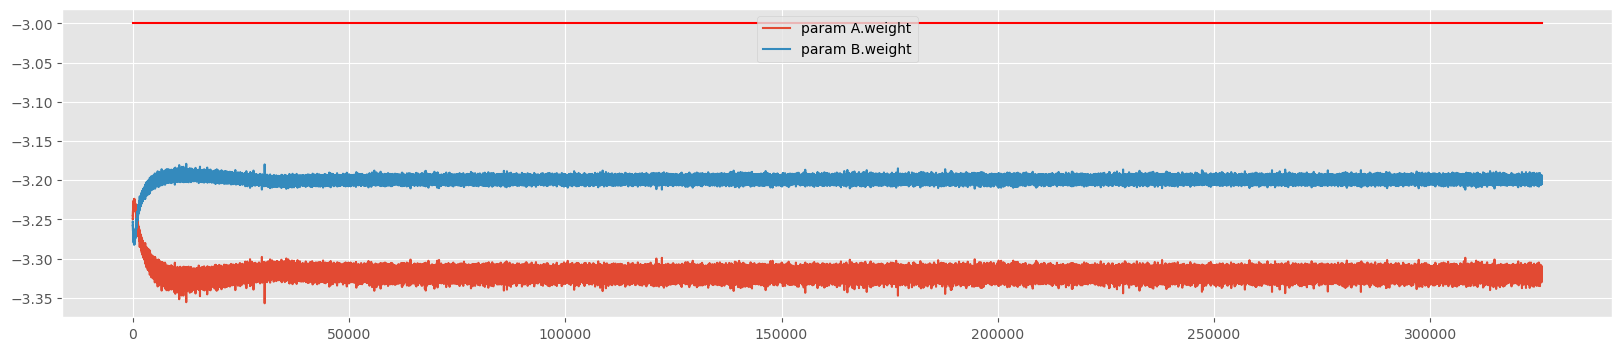

In [43]:

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
legends = []
for i, (name, p) in enumerate(model.named_parameters()):
    plt.plot([ratios[j][i] for j in range(len(ratios))])
    legends.append('param {}'.format(name))
plt.plot([0, len(ratios)], [-3, -3], 'r')
plt.legend(legends)


How do you make sure the learing rate is good? Look at the above plots and suppose we have $log(LR * ratio) = -5$. Then $LR * ratio = 10^{-5}$. Assuming the ratio does not vary much, this probably means we need to increase the learing rate $LR$. Similarly for a reverse direction.